In [8]:
from IPython.display import display, Markdown

import pandas as pd
import gc
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder

# XGBoost
import xgboost as xgb

In [2]:
"""
Columns
The following columns are available on the training set:

accepts_mercadopago Whether the item accepts Mercado Pago
available_quantity The available stock quantity at that moment
avg_asp_item_bday Average selling price of this item over the last days
avg_asp_item_domain Average price of items of the domain this item belongs to
avg_asp_item_sel Average price of seller sales
avg_gmv_item_bday average revenue generated by the item per day
avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
avg_gmv_item_sel Average revenue of items of this seller
avg_gmv_seller_bday Average revenue this seller makes by day
avg_orders_item_bday Average number of orders this item has by day
avg_orders_seller_bday Average orders the seller has by day
avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
avg_si_item_bday Average units sold this item has by day
avg_si_item_sel_30day Average units sold of an item of this seller on the past month
avg_visits_item Average visits this item had
benefit Ignore, should be dropped
boosted Whether the item was boosted
buy_server_timestamp Timestamp of the purchase
category_id Category of this item
conversion Target variable, it is True if this print has an attributed order
cus_cust_id Buyer id
cus_cust_id_sel Seller id
date Print date
deal_print_id Unique id for the print
decimals Ignore, will be dropped
domain_id Domain id for the item
etl_version Ignore, should be dropped
free_shipping Whether the item has free shipping
fulfillment Whether the item is fulfilled by MeLi
full_name Category full name
health Item health
is_pdp Whether the click landed on a PDP
product_id Product_id of the item
item_id ID of the item, useful for debugging
listing_type_id Whether the item is gold or not
logistic_type Logistic type for the item
main_picture URL for the main item picture
offset On which page the item was rendered
original_price Price from which the discount was done
platform Which platform the user is using
price Item price
print_position Position on the page
print_server_timestamp Timestamp for the print
qty_items_dom Number of items this domain has
qty_items_sel Number of items the seller has
rn Leftover from the ETL, Discard
ROW_ID Row of the submission file
site_id Site ID
sold_quantity Number of items sold at the moment of the print
tags Tags the item had at the moment of the print
title Item title
total_asp_item_domain_30days Average selling price of the items of the domain
total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
total_gmv_domain_30days Total revenue the domain made on the last 30 days
total_gmv_domain_bday total_gmv_domain_30days / 30
total_gmv_item_30days Total revenue made by the item on the lasts 30 days
total_gmv_seller Total revenue made by the seller on the last month
total_items_domain Number of items on the domain
total_items_seller Number of items the seller has
total_orders_domain_30days Total orders on the domain
total_orders_item_30days Total orders the Item had on the last 30 days
total_orders_sel_30days Total orders for the seller
total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
total_si_sel_30days Same for the seller
total_visits_domain Total visits on this domain
total_visits_item Total visits this item had
total_visits_seller Total visits for this seller
uid session id
user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

In [9]:
def load_comp():
    # Load the competition data
    comp_data = pd.read_csv("data/competition_data.csv")
    comp_data = comp_data.drop(
        columns=[
            "benefit", 
            "etl_version", 
            "uid",
            "date",
            "deal_print_id",
            "full_name",
            "main_picture",
            "warranty",
            "tags",
            "print_server_timestamp",
            "print_position",
            "title",
            "accepts_mercadopago"
        ]
    )
    # OHE comp_data columns
    comp_data = pd.get_dummies(comp_data, 
        sparse=True,
        columns=[
            #"category_id", 
            #"domain_id", 
            "logistic_type", 
            "platform", 
            "site_id"
        ],
        dtype=int
    )
    #comp_data["accepts_mercadopago"] = comp_data["accepts_mercadopago"].astype(int)
    # todos aceptan mercadopago
    comp_data["boosted"] = comp_data["boosted"].astype(int)
    comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
    comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

    #comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)
    #comp_data["warranty"] = comp_data["warranty"].astype(int)

    # comp_data["listing_type_id"] to 0 if gold_special, 1 if gold_pro.
    comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)
    
    # Label encode category_id and domain_id
    # comp_data["category_id"] = comp_data["category_id"].astype("category")#.cat.codes
    #comp_data["domain_id"] = comp_data["domain_id"].astype("category")#.cat.codes

    # sklearn LabelEncoder for category_id and domain_id
    le = LabelEncoder()
    comp_data["category_id"] = le.fit_transform(comp_data["category_id"])
    comp_data["domain_id"] = le.fit_transform(comp_data["domain_id"])

    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["cheaper_than_original"] = comp_data["price_diff"].apply(lambda x: 1 if x < 0 else 0)
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    #comp_data["cheaper_than_avg"] = comp_data["price"] - comp_data["avg_asp_item_domain"]
    #comp_data["cheaper_than_avg"] = comp_data["cheaper_than_avg"].apply(lambda x: 1 if x < 0 else 0).astype(int)

    # Drop useless columns
    # comp_data = comp_data.drop(
    #     columns=[
    #     ]
    # )

    return comp_data

In [5]:
comp_data = load_comp()
comp_data["conversion"].value_counts()

0.0    164017
1.0     16744
Name: conversion, dtype: int64

In [10]:
# Split into training and evaluation samples
comp_data = load_comp()

display(
    Markdown(
        "\n".join(
            [
                "- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                zip(comp_data.columns, comp_data.dtypes)
            ]
        )
    )
)

full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
del comp_data
gc.collect()

train_data, test_data = train_test_split(full_data, test_size=0.20, train_size=0.80, random_state=42)

y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

- **accepts_mercadopago** (int64) 

 1    199972
Name: accepts_mercadopago, dtype: int64
- **available_quantity** (int64) 

 1        5041
2        4272
3        3744
4        3657
5        3111
         ... 
3145        1
7041        1
19730       1
7929        1
37905       1
Name: available_quantity, Length: 6937, dtype: int64
- **avg_gmv_item_domain_30days** (float64) 

 144.419645    1332
144.390746    1192
169.234106     994
151.463589     991
145.804494     985
              ... 
401.363777       1
136.372464       1
40.951290        1
22.593832        1
174.079162       1
Name: avg_gmv_item_domain_30days, Length: 17727, dtype: int64
- **avg_gmv_item_sel** (float64) 

 228.776307      578
10406.540727    540
213.130612      489
182.490736      474
214.441442      474
               ... 
164.803436        1
52.976757         1
60.970952         1
125.980833        1
23.151458         1
Name: avg_gmv_item_sel, Length: 18652, dtype: int64
- **avg_gmv_seller_bday** (float64) 

 16479.520000    578
19078.658000    540
14869.412333    489
12074.803667    474
15068.085333    474
               ... 
7546.452333       1
167.065333        1
424.793000        1
831.559667        1
37.042333         1
Name: avg_gmv_seller_bday, Length: 18634, dtype: int64
- **avg_qty_orders_item_domain_30days** (float64) 

 2.927004    1332
2.919493    1192
3.505991     994
2.988779     991
2.917104     985
            ... 
2.910275       1
1.456693       1
2.448889       1
3.390135       1
5.377246       1
Name: avg_qty_orders_item_domain_30days, Length: 16760, dtype: int64
- **avg_qty_orders_item_sel_30days** (float64) 

 4.282277      578
258.363636    540
4.302914      489
3.109320      474
4.266129      474
             ... 
2.147826        1
1.765217        1
21.280488       1
3.675926        1
1.676829        1
Name: avg_qty_orders_item_sel_30days, Length: 15129, dtype: int64
- **avg_si_item_sel_30day** (float64) 

 4.342897      578
288.854545    540
4.413760      489
3.153149      474
4.372865      474
             ... 
14.172414       1
5.057971        1
5.568465        1
2.041667        1
2.104167        1
Name: avg_si_item_sel_30day, Length: 15527, dtype: int64
- **boosted** (int64) 

 0    199972
Name: boosted, dtype: int64
- **category_id** (int64) 

 62      12333
49       8641
611      5870
1        5446
518      4154
        ...  
1105        1
1634        1
794         1
1395        1
2257        1
Name: category_id, Length: 2284, dtype: int64
- **conversion** (float64) 

 0.0    164017
1.0     16744
Name: conversion, dtype: int64
- **domain_id** (int64) 

 1380    18203
299      8641
1512     5446
776      4966
742      3151
        ...  
440         1
1138        1
1063        1
448         1
506         1
Name: domain_id, Length: 1742, dtype: int64
- **free_shipping** (int64) 

 0    120063
1     79909
Name: free_shipping, dtype: int64
- **fulfillment** (int64) 

 0    150890
1     49082
Name: fulfillment, dtype: int64
- **health** (float64) 

 0.90    29879
0.80    26008
0.81    22010
0.77    18326
0.88    17643
1.00    16830
0.72    10282
0.83     9896
0.70     7913
0.87     7358
0.91     6497
0.75     6177
0.66     3848
0.00     3819
0.63     3503
0.85     2767
0.60     1344
0.54      920
0.84      790
0.76      754
0.58      697
0.50      660
0.92      444
0.71      430
0.57      415
0.55      249
0.62      206
0.69      148
0.45       69
0.42       54
0.61       21
0.44        7
0.40        4
0.36        2
0.53        2
Name: health, dtype: int64
- **is_pdp** (object) 

 False    109136
True        652
Name: is_pdp, dtype: int64
- **product_id** (float64) 

 15190794.0    662
15315495.0    662
15582422.0    629
8730036.0     516
14542731.0    468
             ... 
13238064.0      1
8988820.0       1
15272931.0      1
13255928.0      1
12308454.0      1
Name: product_id, Length: 4440, dtype: int64
- **item_id** (object) 

 MLA784334044    717
MLA764888251    701
MLA847531773    622
MLA785891221    535
MLA766402693    517
               ... 
MLA833936427      1
MLA663926326      1
MLA784136287      1
MLA812482695      1
MLA762298064      1
Name: item_id, Length: 27695, dtype: int64
- **listing_type_id** (int64) 

 0    165219
1     34753
Name: listing_type_id, dtype: int64
- **offset** (int64) 

 0       69008
48      28743
96      18677
144     13473
192     10561
        ...  
6288        1
7248        1
7008        1
7680        1
7152        1
Name: offset, Length: 209, dtype: int64
- **original_price** (int64) 

 1999     3280
999      2250
2999     1979
699      1760
3999     1670
         ... 
6052        1
7381        1
3881        1
2151        1
14374       1
Name: original_price, Length: 6469, dtype: int64
- **price** (int64) 

 2999     1781
1999     1741
1599     1688
3299     1645
999      1573
         ... 
3843        1
2268        1
54990       1
9668        1
21237       1
Name: price, Length: 6029, dtype: int64
- **qty_items_dom** (float64) 

 20097.0    1332
20495.0    1192
24036.0     994
23081.0     991
21364.0     985
           ... 
4538.0        1
2869.0        1
2849.0        1
6254.0        1
2760.0        1
Name: qty_items_dom, Length: 4193, dtype: int64
- **qty_items_sel** (float64) 

 50.0      1904
51.0      1427
55.0      1108
73.0      1083
53.0       994
          ... 
678.0        1
1138.0       1
1607.0       1
1195.0       1
2284.0       1
Name: qty_items_sel, Length: 1462, dtype: int64
- **sold_quantity** (int64) 

 1        2892
2        2721
3        2684
0        2661
4        2445
         ... 
4065        1
2718        1
7318        1
13288       1
3010        1
Name: sold_quantity, Length: 5718, dtype: int64
- **total_asp_item_domain_30days** (float64) 

 55.778233    1332
55.962392    1192
54.675241     994
56.862608     991
56.362453     985
             ... 
11.691916       1
16.234278       1
17.845285       1
33.731286       1
30.710993       1
Name: total_asp_item_domain_30days, Length: 17729, dtype: int64
- **total_asp_item_sel_30days** (float64) 

 52.675575    578
38.512522    540
51.464741    489
53.133151    474
51.914352    474
            ... 
6.484324       1
14.827999      1
28.673431      1
50.753049      1
10.497735      1
Name: total_asp_item_sel_30days, Length: 18651, dtype: int64
- **total_gmv_domain_bday** (float64) 

 96746.720333     1332
98642.944667     1192
135590.366000     994
116531.036667     991
103832.240000     985
                 ... 
17499.460667        1
1900.123000         1
169.265333          1
206.357000          1
969.040667          1
Name: total_gmv_domain_bday, Length: 17717, dtype: int64
- **total_gmv_item_30days** (float64) 

 56749.36    207
205.13      191
7464.25     176
16430.75    172
3923.66     159
           ... 
224.80        1
642.31        1
1251.60       1
112.82        1
86.74         1
Name: total_gmv_item_30days, Length: 45132, dtype: int64
- **total_items_domain** (int64) 

 149989    1401
149263    1194
166723     994
141335     993
147132     985
          ... 
4090         1
2201         1
23088        1
5779         1
2675         1
Name: total_items_domain, Length: 10309, dtype: int64
- **total_items_seller** (int64) 

 68       1340
86        783
84        777
69        698
11678     578
         ... 
1895        1
2464        1
1757        1
1678        1
3692        1
Name: total_items_seller, Length: 3240, dtype: int64
- **total_orders_domain_30days** (float64) 

 58824.0    1332
59835.0    1192
84270.0     994
68984.0     991
62321.0     985
           ... 
21225.0       1
9182.0        1
7520.0        1
7659.0        1
4857.0        1
Name: total_orders_domain_30days, Length: 7882, dtype: int64
- **total_orders_item_30days** (float64) 

 1.0      11380
3.0       9192
2.0       9043
4.0       7991
5.0       6995
         ...  
539.0        1
669.0        1
328.0        1
642.0        1
384.0        1
Name: total_orders_item_30days, Length: 635, dtype: int64
- **total_orders_sel_30days** (float64) 

 9254.0     578
14210.0    540
9006.0     489
6172.0     474
8993.0     474
          ... 
6800.0       1
3885.0       1
3113.0       1
856.0        1
3689.0       1
Name: total_orders_sel_30days, Length: 4413, dtype: int64
- **total_si_domain_30days** (float64) 

 59860.0    1332
60927.0    1192
85853.0     994
70300.0     991
63507.0     985
           ... 
8811.0        1
8356.0        1
3205.0        1
3487.0        1
14509.0       1
Name: total_si_domain_30days, Length: 9157, dtype: int64
- **total_si_item_30days** (float64) 

 1.0       10324
2.0        8033
3.0        7747
4.0        6878
5.0        6315
          ...  
672.0         1
1129.0        1
608.0         1
700.0         1
971.0         1
Name: total_si_item_30days, Length: 850, dtype: int64
- **total_si_sel_30days** (float64) 

 9385.0     578
15887.0    540
9238.0     489
9218.0     474
6259.0     474
          ... 
3708.0       1
4848.0       1
13328.0      1
4714.0       1
3928.0       1
Name: total_si_sel_30days, Length: 5301, dtype: int64
- **total_visits_domain** (int64) 

 9324517     1401
9042945     1194
13032888     994
7310127      993
8422586      985
            ... 
1198950        1
139838         1
134867         1
68667          1
39030          1
Name: total_visits_domain, Length: 17646, dtype: int64
- **total_visits_item** (int64) 

 256      298
279      269
24       262
77       245
305      244
        ... 
11880      1
2483       1
7678       1
9602       1
6251       1
Name: total_visits_item, Length: 9618, dtype: int64
- **total_visits_seller** (int64) 

 1324179    578
1375253    558
803487     540
1353845    478
1267081    474
          ... 
23854        1
30964        1
44695        1
27382        1
7358         1
Name: total_visits_seller, Length: 17762, dtype: int64
- **user_id** (float64) 

 33380364.0     49
302970143.0    25
136144636.0    21
307287134.0    20
212372566.0    18
               ..
158113079.0     1
140695408.0     1
513841702.0     1
210755401.0     1
485647845.0     1
Name: user_id, Length: 139110, dtype: int64
- **ROW_ID** (float64) 

 0.0        1
12813.0    1
12811.0    1
12810.0    1
12809.0    1
          ..
6403.0     1
6402.0     1
6401.0     1
6400.0     1
19210.0    1
Name: ROW_ID, Length: 19211, dtype: int64
- **logistic_type_cross_docking** (Sparse[int64, 0]) 

 1    108346
0     91626
Name: logistic_type_cross_docking, dtype: int64
- **logistic_type_custom** (Sparse[int64, 0]) 

 0    196272
1      3700
Name: logistic_type_custom, dtype: int64
- **logistic_type_default** (Sparse[int64, 0]) 

 0    199645
1       327
Name: logistic_type_default, dtype: int64
- **logistic_type_drop_off** (Sparse[int64, 0]) 

 0    175855
1     24117
Name: logistic_type_drop_off, dtype: int64
- **logistic_type_fulfillment** (Sparse[int64, 0]) 

 0    150890
1     49082
Name: logistic_type_fulfillment, dtype: int64
- **logistic_type_not_specified** (Sparse[int64, 0]) 

 0    193058
1      6914
Name: logistic_type_not_specified, dtype: int64
- **logistic_type_xd_drop_off** (Sparse[int64, 0]) 

 0    192486
1      7486
Name: logistic_type_xd_drop_off, dtype: int64
- **platform_/mobile/android** (Sparse[int64, 0]) 

 1    124781
0     75191
Name: platform_/mobile/android, dtype: int64
- **platform_/mobile/ios** (Sparse[int64, 0]) 

 0    185765
1     14207
Name: platform_/mobile/ios, dtype: int64
- **platform_/web/desktop** (Sparse[int64, 0]) 

 0    164080
1     35892
Name: platform_/web/desktop, dtype: int64
- **platform_/web/mobile** (Sparse[int64, 0]) 

 0    174880
1     25092
Name: platform_/web/mobile, dtype: int64
- **site_id_MLA** (Sparse[int64, 0]) 

 1    199972
Name: site_id_MLA, dtype: int64
- **price_diff** (int64) 

 100     2965
200     2952
300     2376
50      1952
400     1893
        ... 
3451       1
1494       1
3855       1
2525       1
2875       1
Name: price_diff, Length: 3350, dtype: int64
- **cheaper_than_original** (int64) 

 1    199972
Name: cheaper_than_original, dtype: int64

0

In [78]:
# Decision Tree Classifier with K-Fold Cross Validation and Randomized Search CV

dtc = make_pipeline(
    SimpleImputer(),
    RandomizedSearchCV(
        DecisionTreeClassifier(random_state=2345),
        param_distributions={
            "max_depth": [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64, 128, 256, 512],
            "min_samples_leaf": [2, 4, 8, 16, 32, 64, 128, 256, 512],
            "max_features": [2, 4, 8, 16, 32, 64, 128, 256, 512, None],
        },
        n_iter=100,
        cv=3,
        random_state=2345,
        n_jobs=-1,
        verbose=0,
    )
)

kf = KFold(n_splits=5, random_state=2345, shuffle=True)
roc_aucs = []

for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    dtc.fit(X_train_kf, y_train_kf)
    # Metric: roc_auc_score
    roc_aucs.append(roc_auc_score(y_valid_kf, dtc.predict_proba(X_valid_kf)[:, dtc.classes_ == 1]))
    print(f"ROC-AUC split {len(roc_aucs)}: ", roc_aucs[-1])

print("ROC-AUC mean: ", sum(roc_aucs) / len(roc_aucs))    

dtc.fit(X_train, y_train)

print("ROC-AUC: ", roc_auc_score(y_test, dtc.predict_proba(X_test)[:, dtc.classes_ == 1]))

ROC-AUC split 1:  0.7062813104270844


KeyboardInterrupt: 

In [21]:
pd.Series(roc_aucs).describe()

count    5.000000
mean     0.719648
std      0.005229
min      0.714328
25%      0.715559
50%      0.717973
75%      0.724961
max      0.725421
dtype: float64

In [ ]:
rfs = make_pipeline(
    SimpleImputer(),
    RandomizedSearchCV(
        RandomForestClassifier(random_state=2345),
        param_distributions={
            "max_depth": [2, 4, 8, 16, 32, 64, 128, None],
            "min_samples_split": [2, 4, 8, 16, 32, 64, 128],
            "min_samples_leaf": [2, 4, 8, 16, 32, 64, 128],
            "max_features": [2, 4, 8, 16, 32, 64, 128, None],
        },
        n_iter=100,
        cv=3,
        random_state=2345,
        n_jobs=-1,
        verbose=2,
    )
)

rfs.fit(X_train, y_train)

In [34]:
space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, 256, 512, None]),
    "min_samples_split": hp.choice("min_samples_split", [2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "min_samples_leaf": hp.choice("min_samples_leaf", [2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "max_features": hp.choice("max_features", [2, 4, 8, 16, 32, 64, 128, 256, 512, None]),
}

def objective_dct(params):

    kf = KFold(n_splits=10, shuffle=True)

    model = make_pipeline(
        SimpleImputer(),
        DecisionTreeClassifier(**params),
    )

    score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
    # model.fit(X_train, y_train)

    # y_pred = model.predict_proba(X_test)[:, model.classes_ == 1]
    # score = roc_auc_score(y_test, y_pred)

    return {"loss": 1 - score, "status": STATUS_OK}


trials_dct = Trials()

best_dct = fmin(
    fn=objective_dct,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_dct,
)

print(best_dct)

100%|██████████| 100/100 [09:50<00:00,  5.90s/trial, best loss: 0.26513219216768746]
{'max_depth': 2, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 8}


In [35]:
#best_dct = {'max_depth': 2, 'max_features': 6, 'min_samples_leaf': 6, 'min_samples_split': 6}

hyper_dct = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(**best_dct)
)

hyper_dct.fit(X_train, y_train)

# kf = KFold(n_splits=10, random_state=2345, shuffle=True)
# roc_auc_scores_hdct = []

# for train_index, valid_index in kf.split(X_train):

#     X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
#     y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

#     hyper_dct.fit(X_train_kf, y_train_kf)
#     # Metric: roc_auc_score
#     roc_auc_scores_hdct.append(roc_auc_score(y_valid_kf, hyper_dct.predict_proba(X_valid_kf)[:, hyper_dct.classes_ == 1]))
#     print(f"ROC-AUC split {len(roc_auc_scores_hdct)}: ", roc_auc_scores_hdct[-1])

print("ROC-AUC: ", roc_auc_score(y_test, hyper_dct.predict_proba(X_test)[:, hyper_dct.classes_ == 1]))

ROC-AUC:  0.6579065690644064


In [39]:
hyper_dct.named_steps["decisiontreeclassifier"]

DecisionTreeClassifier(max_depth=2, max_features=5, min_samples_leaf=6,
                       min_samples_split=8)

[Text(0.5, 0.8333333333333334, 'total_visits_item <= 3133.5\ngini = 0.167\nsamples = 162684\nvalue = [147685, 14999]'),
 Text(0.25, 0.5, 'total_gmv_item_30days <= 270.81\ngini = 0.115\nsamples = 106254\nvalue = [99757, 6497]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.089\nsamples = 52476\nvalue = [50015, 2461]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.139\nsamples = 53778\nvalue = [49742, 4036]'),
 Text(0.75, 0.5, 'total_gmv_item_30days <= 3918.475\ngini = 0.256\nsamples = 56430\nvalue = [47928, 8502]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.214\nsamples = 33062\nvalue = [29031, 4031]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.309\nsamples = 23368\nvalue = [18897, 4471]')]

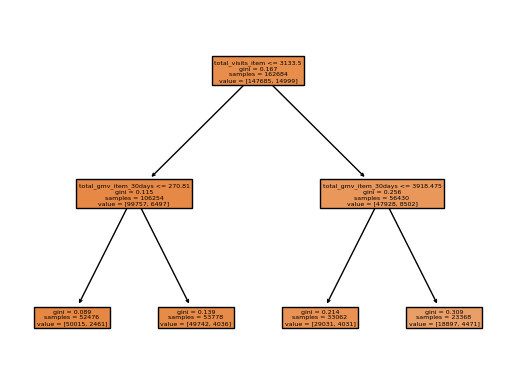

In [40]:
plot_tree(hyper_dct.named_steps["decisiontreeclassifier"], max_depth=2, filled=True, feature_names=list(X_train.columns))

In [48]:
space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "min_samples_split": hp.choice("min_samples_split", [2, 4, 8, 16, 32, 64, 128]),
    "min_samples_leaf": hp.choice("min_samples_leaf", [2, 4, 8, 16, 32, 64, 128]),
    "max_features": hp.choice("max_features", [2, 4, 8, 16, 32, 64, 128, None]),
}

def objective_rfs(params):
    model = make_pipeline(
        SimpleImputer(),
        RandomForestClassifier(**params, n_estimators=100, n_jobs=-1),
    )

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, model.classes_ == 1]
    score = roc_auc_score(y_test, y_pred)

    return {"loss": 1 - score, "status": STATUS_OK}

trials_rfs = Trials()

best_rfs = fmin(
    fn=objective_rfs,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_rfs,
)

print(best_rfs)

100%|██████████| 100/100 [38:51<00:00, 23.32s/trial, best loss: 0.2121955631253214] 
{'max_depth': 3, 'max_features': 0, 'min_samples_leaf': 2, 'min_samples_split': 0}


In [58]:
best_rfs["max_features"] = 1
best_rfs["min_samples_split"] = 2

best_rfs

{'max_depth': 3,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [63]:
hyper_rfs_kf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

kf = KFold(n_splits=10, random_state=2345, shuffle=True)

roc_auc_scores_hrfs = []

for train_index, valid_index in kf.split(X_train):
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[valid_index]

    hyper_rfs_kf.fit(X_train_kf, y_train_kf)
    # Metric: roc_auc_score
    roc_auc_scores_hrfs.append(roc_auc_score(y_valid_kf, hyper_rfs_kf.predict_proba(X_valid_kf)[:, hyper_rfs_kf.classes_ == 1]))
    print(f"ROC-AUC split {len(roc_auc_scores_hrfs)}: ", roc_auc_scores_hrfs[-1])

print("ROC-AUC: ", roc_auc_score(y_test, hyper_rfs_kf.predict_proba(X_test)[:, hyper_rfs_kf.classes_ == 1]))

ROC-AUC split 1:  0.7081469103022364
ROC-AUC split 2:  0.7180935208870816
ROC-AUC split 3:  0.7089286667318965
ROC-AUC split 4:  0.7101126956253258
ROC-AUC split 5:  0.7035800560823728
ROC-AUC split 6:  0.7119053126906797
ROC-AUC split 7:  0.7110893194102677
ROC-AUC split 8:  0.7074769409294601
ROC-AUC split 9:  0.7048135724185971
ROC-AUC split 10:  0.7231767164494025
ROC-AUC:  0.721804311959505


In [18]:
best_rfs = {
    'max_depth': 3,
    'max_features': 1,
    'min_samples_leaf': 2,
    'min_samples_split': 2
}

hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

hyper_rfs.fit(X_train, y_train)

roc_auc_score(y_test, hyper_rfs.predict_proba(X_test)[:, hyper_rfs.classes_ == 1])

0.7142635583841591

In [18]:
y_preds_cls = dtc.predict_proba(X_test)[:, dtc.classes_ == 1].squeeze()
roc_auc_score(y_test, y_preds_cls)

0.6994391273622476

In [47]:
#cls.score(X_validation, y_validation)

y_preds_rfs = rfs.predict_proba(X_test)[:, rfs.classes_ == 1].squeeze()
roc_auc_score(y_test, y_preds_rfs)

0.729350839606164

In [15]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
)

#xgb_model.fit(X_train, y_train)
#roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(xgb_model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1, verbose=2).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


KeyboardInterrupt: 

In [28]:
xgb.set_config(verbosity=1)

In [31]:
# Pandas hide UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [53]:
# XGBoost with Hyperopt

warnings.filterwarnings("ignore", category=UserWarning)

xgb_space = {
    "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
    "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
    "subsample": hp.uniform("subsample", 0.5, 1),
}

X_train_, X_eval, y_train_, y_eval = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80, random_state=42)

# best_score = 0
def objective_xgb(params):
    # global best_score

    #kf = KFold(n_splits=10, shuffle=True)

    model =  xgb.XGBClassifier(
        **params,
        early_stopping_rounds=10,
        eval_metric="auc",
    )

    #score = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
    

    model.fit(X_train_, y_train_, eval_set=[(X_eval, y_eval)], verbose=False)

    score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])
    
    print(f"Score: {score}", params)

    # if score > best_score:
        # best_score = score
        # print(f"New best score: {best_score}")
        # print(params)
        
    return {"loss": 1 - score, "status": STATUS_OK}

trials_xgb = Trials()

best_xgb = fmin(
    fn=objective_xgb,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_xgb,
    verbose=2,
)

print(best_xgb)

Score: 0.7835950626541037                              
{'colsample_bytree': 0.9865558697264714, 'gamma': 0.12929172488084684, 'learning_rate': 0.13214872804415695, 'max_depth': 4, 'min_child_weight': 64, 'n_estimators': 200, 'subsample': 0.5444889526426269}
Score: 0.790444423930476                                                          
{'colsample_bytree': 0.8378308377556504, 'gamma': 0.15657840294680325, 'learning_rate': 0.090944395149636, 'max_depth': 64, 'min_child_weight': 32, 'n_estimators': 200, 'subsample': 0.9100842750536129}
Score: 0.786913381471421                                                          
{'colsample_bytree': 0.7701622227291531, 'gamma': 0.9080241945183694, 'learning_rate': 0.0848206061070631, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.7093527339303067}
Score: 0.7857134122233864                                                         
{'colsample_bytree': 0.9204395835391892, 'gamma': 0.21033686310911281, 'learning_rate': 0.

In [54]:
# best_xgb = {'colsample_bytree': 0.6278514796444425,
#  'learning_rate': 0.07068021279873352,
#  'max_depth': 7,
#  'n_estimators': 4,
#  'subsample': 0.763643037745022}

best_xgb

{'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
)

#xgb_model.fit(X_train, y_train)
#roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(xgb_model, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1, verbose=2).mean()

In [46]:
params = {
    'colsample_bytree': 0.6278514796444425,
    'learning_rate': 0.07068021279873352,
    'max_depth': 7,
    'n_estimators': 4,
    'subsample': 0.763643037745022
}

xgb_kf = make_pipeline(
    #SimpleImputer(),
    xgb.XGBClassifier(
        **params,
        missing=-999,
        n_jobs=-1,
    )
)

#xgb_kf.fit(X_train, y_train, verbose = True)
#roc_auc_score(y_test, xgb_kf.predict_proba(X_test)[:, xgb_kf.classes_ == 1])

kf = KFold(n_splits=10, shuffle=True)

cross_val_score(
    xgb_kf, 
    X_train, y_train, 
    scoring="roc_auc", 
    cv=KFold(n_splits=10, shuffle=True), 
    n_jobs=-1, 
    verbose=10
).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.753) total time=   3.7s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.761) total time=   4.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.0s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.1s remaining:    2.6s


[CV] END ................................ score: (test=0.747) total time=   4.2s
[CV] END ................................ score: (test=0.745) total time=   4.1s
[CV] END ................................ score: (test=0.751) total time=   4.2s
[CV] END ................................ score: (test=0.746) total time=   2.7s
[CV] END ................................ score: (test=0.752) total time=   2.6s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished


0.751205010063007

In [82]:
params_colab1 = {
  'colsample_bytree': 0.8337751225603421,
 'gamma': 0.869242256759736,
 'learning_rate': 0.1452990294484685,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 4,
 'subsample': 0.850647916320707
}

hyper_xgb_colab1 = xgb.XGBClassifier(
        **params_colab1,
        missing=-999,
        n_jobs=-1,
        #tree_method='gpu_hist',
    )

hyper_xgb_colab1.fit(X_train, y_train)
roc_auc_score(y_test, hyper_xgb_colab1.predict_proba(X_test)[:, xgb_kf.classes_ == 1])

0.7560540929493644

In [47]:
hyper_xgb_kf = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
    n_jobs=-1,
)

kf = KFold(n_splits=10, shuffle=True)
#hyper_xgb.fit(X_train, y_train)
cross_val_score(hyper_xgb_kf, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()

0.7434762707253941

In [57]:
best_xgb

{'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

In [60]:
hyper_xgb2_params1 = {'colsample_bytree': 0.8026984951481873,
 'gamma': 0.3418442916901452,
 'learning_rate': 0.04071215589522034,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 4,
 'subsample': 0.6046506428505479}

hyper_xgb2 = xgb.XGBClassifier(
        **hyper_xgb2_params1,
        missing=-999,
        n_jobs=-1,
    )
#kf = KFold(n_splits=10, shuffle=True)
#cross_val_score(hyper_xgb_kf, X_train, y_train, scoring="roc_auc", cv=kf, n_jobs=-1).mean()
hyper_xgb2.fit(X_train, y_train)
roc_auc_score(y_test, hyper_xgb2.predict_proba(X_test)[:, hyper_xgb2.classes_ == 1])

0.7229693543206894

In [31]:
# Ensemble best RFS and XGB

best_rfs = {
    'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2
}

hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

# best_xgb = {'colsample_bytree': 0.6580566715010197, 'learning_rate': 0.04956976966729988, 'max_depth': None, 'n_estimators': 500, 'subsample': 0.7679968914163563}

hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

# Ensemble best RFS and XGB

from sklearn.ensemble import VotingClassifier

voting_rfs_xgb = VotingClassifier(
    estimators=[
        ("rfs", hyper_rfs),
        ("xgb", hyper_xgb),
    ],
    voting="soft",
    n_jobs=-1,
    verbose=True,
)

voting_rfs_xgb.fit(X_train, y_train)

roc_auc_score(y_test, voting_rfs_xgb.predict_proba(X_test)[:, voting_rfs_xgb.classes_ == 1])

[Voting] ...................... (1 of 2) Processing rfs, total=   1.0s
[Voting] ...................... (2 of 2) Processing xgb, total=   2.8s


0.7429049409565275

In [28]:
hyper_rfs = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(**best_rfs, n_estimators=100, n_jobs=-1)
)

hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

voting_rfs_xgb = VotingClassifier(
    estimators=[
        ("rfs", hyper_rfs),
        ("xgb", hyper_xgb),
    ],
    voting="soft",
    n_jobs=-1,
    verbose=True,
)

voting_rfs_xgb.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

[Voting] ...................... (1 of 2) Processing rfs, total=   1.5s
[Voting] ...................... (2 of 2) Processing xgb, total=   3.2s


VotingClassifier(estimators=[('rfs',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(max_depth=3,
                                                                      max_features=1,
                                                                      min_samples_leaf=2,
                                                                      n_jobs=-1))])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6278514796444425,
                                            early_st...
                                            interaction_constraints=None,
                                            learning_rate=0.07068021279873352,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=-999,
                                            monotone_constraints=None,
                                            n_estimators=4, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 n_jobs=-1, verbose=True, voting='soft')

In [ ]:
hyper_xgb = xgb.XGBClassifier(
    **best_xgb,
    missing=-999,
)

hyper_xgb.fit(X_train, y_train)

roc_auc_score(y_test, hyper_xgb.predict_proba(X_test)[:, hyper_xgb.classes_ == 1])

In [10]:
    model = xgb_kf

    comp_data = load_comp()#pd.read_csv("data/competition_data.csv")
    eval_data = comp_data[comp_data["ROW_ID"].notna()]
    del comp_data

    # Predict on the evaluation set
    eval_data = eval_data.drop(columns=["conversion"])
    eval_data = eval_data.select_dtypes(include='number')
    y_preds = model.predict_proba(eval_data.drop(columns=["ROW_ID"]))[:, model.classes_ == 1].squeeze()

    # Make the submission file
    submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
    submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
    submission_df.to_csv("los_simuladores_XGB_HP_KF.csv", sep=",", index=False)

    del eval_data
    del submission_df
    gc.collect()

0

In [6]:
from IPython.display import display, Markdown

import pandas as pd
import gc

# Keras

from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# LabelEncoder

from sklearn.preprocessing import LabelEncoder

# Train Test Split

from sklearn.model_selection import train_test_split


# Imputer

from sklearn.impute import SimpleImputer

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'

In [11]:
X_train.shape[1]

52

In [1]:
cnn = Sequential([
    Dense(52, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam', 
    metrics=[AUC(curve='ROC'), 'accuracy'],
)

imputed_X_train = SimpleImputer().fit_transform(X_train)

cnn.fit(
    imputed_X_train, y_train, 
    epochs=10, 
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

NameError: name 'Sequential' is not defined